In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from torch.utils import data
import numpy as np
import torch
import torch.optim as optim

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device(0)

In [6]:
torch.cuda.device_count()

1

In [7]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
# use_image_features=True
# batch_size = 1000
# print_every = 10

# input_options = {1: "resnet 18 image features, question", 2: "resnet 192 image features, question", 3: "new resnet 18 features", 4: "new resnet 152 features"}
# model_input = input_options[3]

# answer_type_options = {1: "yesno", 2: "number", 3: "other"}
# answer_type = answer_type_options[3]

# if answer_type == "yesno":
#   lstm_hidden_size = 64
#   lstm_num_layers = 1  
# else:
#   lstm_hidden_size = 256
#   lstm_num_layers = 1

# fusion_type_options = {1: "concatenation", 2: "pointwise_mul", 3: "try"}
# fusion_type = fusion_type_options[1]

# model_type_options = {1: "simplecnnlstm", 2: "fusion", 3: "transformer"}
# model_type = model_type_options[3]

# #works only for fusion model
# dropout_amount = 0.01

# Top100 = False

use_image_features=True
batch_size = 1000
print_every = 10

input_options = {1: "resnet 18 image features, question", 2: "resnet 192 image features, question", 3: "new resnet 18 features", 4: "new resnet 152 features"}
model_input = input_options[3]

answer_type_options = {1: "yesno", 2: "number", 3: "other"}
answer_type = answer_type_options[3]

if answer_type == "yesno":
  lstm_hidden_size = 64
  lstm_num_layers = 1  
else:
  lstm_hidden_size = 64
  lstm_num_layers = 1

fusion_type_options = {1: "concatenation", 2: "pointwise_mul", 3: "try"}
fusion_type = fusion_type_options[3]

model_type_options = {1: "simplecnnlstm", 2: "fusion", 3: "transformer"}
model_type = model_type_options[2]

#works only for fusion model
dropout_amount = 0.3

shared_size = 128

Top100 = False

#### Load data

In [10]:
new_mapping = {}
train_questions = np.load("train_questions.npy")
val_questions = np.load("val_questions.npy")
cnt = 0
for i in range(train_questions.shape[0]):
  for j in range(train_questions.shape[1]):
    v = train_questions[i][j]
    if v not in new_mapping:
      new_mapping[v] = cnt
      cnt += 1
for i in range(val_questions.shape[0]):
  for j in range(val_questions.shape[1]):
    v = val_questions[i][j]
    if v not in new_mapping:
      new_mapping[v] = cnt
      cnt += 1
print(cnt)

2692


In [15]:
new_mapping2 = {}
train_questions = np.load("train_questions_"+answer_type+".npy")
val_questions = np.load("val_questions_"+answer_type+".npy")
cnt2 = 0
for i in range(train_questions.shape[0]):
  for j in range(train_questions.shape[1]):
    v = train_questions[i][j]
    if v not in new_mapping2:
      new_mapping2[v] = cnt2
      cnt2 += 1
for i in range(val_questions.shape[0]):
  for j in range(val_questions.shape[1]):
    v = val_questions[i][j]
    if v not in new_mapping2:
      new_mapping2[v] = cnt2
      cnt2 += 1
print(cnt2)

2133


In [0]:
# val_questions = np.load("new_filtered_val_questions.npy")
# for i in range(val_questions.shape[0]):
#   for j in range(val_questions.shape[1]):
#     if j!=0 and np.sum(val_questions[i,j:]) == 0:
#       val_questions[i,j:] = 4344
#       break

# print(val_questions[:10])
# np.save("new_filtered_val_questions.npy", val_questions)

In [0]:
from torch.utils import data

if model_input == "resnet 18 image features, question":
  # train_answers = np.load("train_answers_"+answer_type+".npy")
  if Top100 == True:
    train_indices = np.load("top100_train_indices.npy")
    val_indices = np.load("top100_val_indices.npy")
    
  train_answers = np.load("train_answers.npy")
  if Top100 == True:
    
    train_answers = train_answers[train_indices]
    answer_dict = {}
    cnt = 0
    print(train_answers.shape)
    for i in range(train_answers.shape[0]):
      v = train_answers[i][0]
      if v not in answer_dict:
        answer_dict[v] = cnt
        cnt += 1
    print(cnt)

    print(answer_dict)
    for i in range(train_answers.shape[0]):
      train_answers[i,0] = answer_dict[train_answers[i,0]]
    # train_answers = answer_dict[train_answers[:,0]]
    # print(train_answers.shape)

  tensor_train_answers = torch.Tensor(train_answers).flatten()
  tensor_train_answers = tensor_train_answers.type(torch.long)

  # val_answers = np.load("val_answers_"+answer_type+".npy")
  val_answers = np.load("val_answers.npy")
  if Top100 == True:
    val_answers = val_answers[val_indices]
    for i in range(val_answers.shape[0]):
      val_answers[i,0] = answer_dict[val_answers[i,0]]
  tensor_val_answers = torch.Tensor(val_answers).flatten()
  tensor_val_answers = tensor_val_answers.type(torch.long)

  
elif model_input == "resnet 192 image features, question":
  train_answers = np.load("train_answers_"+answer_type+".npy")
  # train_answers = np.load("train_answers.npy")
  tensor_train_answers = torch.Tensor(train_answers).flatten()
  tensor_train_answers = tensor_train_answers.type(torch.long)

  val_answers = np.load("val_answers_"+answer_type+".npy")
  # val_answers = np.load("val_answers.npy")
  tensor_val_answers = torch.Tensor(val_answers).flatten()
  tensor_val_answers = tensor_val_answers.type(torch.long)

  # train_indices = np.load("top100_train_indices.npy")
  # val_indices = np.load("top100_val_indices.npy")
elif model_input == "new resnet 18 features" or model_input == "new resnet 152 features":
  train_answers = np.load("new_filtered_train_answers.npy")
  val_answers = np.load("new_filtered_val_answers.npy")
  # train_answers_copy = np.array(train_answers)
  # train_answers = np.concatenate((train_answers_copy, train_answers_copy), axis=0)
  # train_answers = train_answers[:13000]
  # train_answers = train_answers[:2000]
  # train_answers = np.concatenate((train_answers, val_answers[2600:]), axis=0)
  answers_mapping = np.arange(0,104)
  np.random.shuffle(answers_mapping)
  new_train_answers = np.array(train_answers)
  indices = np.arange(0,104)
  for i in range(104):
    ind = indices[indices==i]
    new_train_answers[ind] = answers_mapping[i]
  train_answers = new_train_answers
  # train_answers = np.load("train_answers.npy")
  tensor_train_answers = torch.Tensor(train_answers).flatten()
  tensor_train_answers = tensor_train_answers.type(torch.long)

  
  # val_answers = val_answers[:2600]
  # val_answers = val_answers[:400]
  new_train_answers = np.array(val_answers)
  indices = np.arange(0,104)
  for i in range(104):
    ind = indices[indices==i]
    new_train_answers[ind] = answers_mapping[i]
  val_answers = new_train_answers
  # val_answers = np.load("val_answers.npy")
  tensor_val_answers = torch.Tensor(val_answers).flatten()
  tensor_val_answers = tensor_val_answers.type(torch.long)

  # train_indices = np.load("top100_train_indices.npy")
  # val_indices = np.load("top100_val_indices.npy")


if model_input == "resnet 18 image features, question":
  # train_images = np.load("train_image_features_"+answer_type+".npy")
  # train_questions = np.load("train_questions_"+answer_type+".npy")

  # val_images = np.load("val_image_features_"+answer_type+".npy")
  # val_questions = np.load("val_questions_"+answer_type+".npy")

  train_images = np.load("train_image_features.npy")
  train_questions = np.load("train_questions.npy")
  for i in range(train_questions.shape[0]):
    for j in range(train_questions.shape[1]):
      v = train_questions[i,j]
      train_questions[i,j] = new_mapping[v]
  # train_questions = train_questions[:,:20]

  if Top100 == True:
    train_images = train_images[train_indices]
    train_questions = train_questions[train_indices]

  val_images = np.load("val_image_features.npy")
  val_questions = np.load("val_questions.npy")
  for i in range(val_questions.shape[0]):
    for j in range(val_questions.shape[1]):
      v = val_questions[i,j]
      val_questions[i,j] = new_mapping[v]

  # val_questions = val_questions[:,:20]

  if Top100 == True:
    val_images = val_images[val_indices]
    val_questions = val_questions[val_indices]

  tensor_train_images = torch.Tensor(train_images)
  tensor_train_questions = torch.Tensor(train_questions)

  tensor_val_images = torch.Tensor(val_images)
  tensor_val_questions = torch.Tensor(val_questions)

  trainset = data.TensorDataset(tensor_train_images,tensor_train_questions,tensor_train_answers)
  valset = data.TensorDataset(tensor_val_images,tensor_val_questions,tensor_val_answers)

  num_workers = 2

elif model_input == "resnet 192 image features, question":
  train_images = np.load("train_image_features_"+answer_type+".npy")
  train_questions = np.load("train_questions_"+answer_type+".npy")

  val_images = np.load("val_image_features_"+answer_type+".npy")
  val_questions = np.load("val_questions_"+answer_type+".npy")
  
  for i in range(train_questions.shape[0]):
    for j in range(train_questions.shape[1]):
      v = train_questions[i,j]
      train_questions[i,j] = new_mapping2[v]


  for i in range(val_questions.shape[0]):
    for j in range(val_questions.shape[1]):
      v = val_questions[i,j]
      val_questions[i,j] = new_mapping2[v]

  tensor_train_images = torch.Tensor(train_images)
  tensor_train_questions = torch.Tensor(train_questions)

  tensor_val_images = torch.Tensor(val_images)
  tensor_val_questions = torch.Tensor(val_questions)

  trainset = data.TensorDataset(tensor_train_images,tensor_train_questions,tensor_train_answers)
  valset = data.TensorDataset(tensor_val_images,tensor_val_questions,tensor_val_answers)

  num_workers = 2

elif model_input == "new resnet 18 features":
  train_images = np.load("new_filtered_train_image_features.npy")
  # train_images_copy = np.array(train_images)
  # noise = np.random.normal(scale=2.0, size=[train_images.shape[0]*train_images.shape[1]])
  # noise = np.reshape(noise, newshape=[train_images.shape[0], train_images.shape[1]])
  # train_images_copy += noise
  # train_images_a = np.array(train_images)
  # train_images = np.concatenate((train_images_a, train_images_copy), axis=0)
  # train_images = train_images[:13000]
  # train_images = train_images[:2000]
  train_questions = np.load("new_filtered_train_questions.npy")
  # train_questions_copy = np.array(train_questions)
  # train_questions = np.concatenate((train_questions_copy, train_questions_copy), axis=0)
  # train_questions = train_questions[:13000]
  # train_questions = train_questions[:2000]

  val_images = np.load("new_filtered_val_image_features.npy")
  
  val_questions = np.load("new_filtered_val_questions.npy")
  

  # print(train_images.shape)
  # train_images = np.concatenate((train_images, val_images[2600:]), axis=0)
  # print(train_images.shape)
  # train_questions = np.concatenate((train_questions, val_questions[2600:]), axis=0)
  # val_images = val_images[:2600]
  # val_questions = val_questions[:2600]
  # val_images = val_images[:400]
  # val_questions = val_questions[:400]
  
  tensor_train_images = torch.Tensor(train_images)
  tensor_train_questions = torch.Tensor(train_questions)

  tensor_val_images = torch.Tensor(val_images)
  tensor_val_questions = torch.Tensor(val_questions)

  # train_question_indices = np.zeros(shape=[train_questions.shape[0], 1])
  # for i in range(train_questions.shape[0]):
  #   for j in range(25):
  #     if train_questions[i,j] == 4344:
  #       train_question_indices[i,0] = j-1
  #       break
  # val_question_indices = np.zeros(shape=[val_questions.shape[0], 1])
  # for i in range(val_questions.shape[0]):
  #   for j in range(25):
  #     if val_questions[i,j] == 4344:
  #       val_question_indices[i,0] = j-1
  #       break
  
  # np.save("new_filtered_train_question_indices.npy", train_question_indices)
  # np.save("new_filtered_val_question_indices.npy", val_question_indices)

  train_question_indices = np.load("new_filtered_train_question_indices.npy")
  # train_question_indices_copy = np.array(train_question_indices)
  # train_question_indices = np.concatenate((train_question_indices_copy, train_question_indices_copy), axis=0)
  # train_question_indices = train_question_indices[:13000]
  # train_question_indices = train_question_indices[:2000]
  val_question_indices = np.load("new_filtered_val_question_indices.npy")
  
  # train_question_indices = np.concatenate((train_question_indices, val_question_indices[2600:]), axis=0)
  # val_question_indices = val_question_indices[:2600]
  # val_question_indices = val_question_indices[:400]

  # train_question_indices[train_question_indices==-1] = 0
  # val_question_indices[val_question_indices==-1] = 0

  # np.save("new_filtered_train_question_indices.npy", train_question_indices)
  # np.save("new_filtered_val_question_indices.npy", val_question_indices)


  # print(train_question_indices[:10])
  # print(train_questions[:10])
  # print(val_question_indices[:10])
  # print(val_questions[:10])
  
  # print(train_answers.shape)
  # print(train_images.shape)
  # print(train_questions.shape)
  # print(train_question_indices.shape)

  tensor_train_question_indices = torch.Tensor(train_question_indices)
  tensor_val_question_indices = torch.Tensor(val_question_indices)

  trainset = data.TensorDataset(tensor_train_images,tensor_train_questions,tensor_train_answers, tensor_train_question_indices)
  valset = data.TensorDataset(tensor_val_images,tensor_val_questions,tensor_val_answers, tensor_val_question_indices)

  num_workers = 2

elif model_input == "new resnet 152 features":
  train_images = np.load("filtered_train_image_features_152.npy")
  train_questions = np.load("filtered_train_questions.npy")

  val_images = np.load("filtered_val_image_features_152.npy")
  val_questions = np.load("filtered_val_questions.npy")
  
  tensor_train_images = torch.Tensor(train_images)
  tensor_train_questions = torch.Tensor(train_questions)

  tensor_val_images = torch.Tensor(val_images)
  tensor_val_questions = torch.Tensor(val_questions)

  trainset = data.TensorDataset(tensor_train_images,tensor_train_questions,tensor_train_answers)
  valset = data.TensorDataset(tensor_val_images,tensor_val_questions,tensor_val_answers)

  num_workers = 2


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [18]:

print(train_images.shape)
print(val_images.shape)

(32498, 512)
(20283, 512)


In [19]:
print(train_questions.shape)
print(val_questions.shape)

(32498, 25)
(20283, 25)


#### Choose model

In [0]:
if model_type == "simplecnnlstm":
  import models.Simple_CNN_LSTM_Model as models
  # import models.trial_model as trial_model
elif model_type == "fusion":
  import models.fusion_model as fusion_model
elif model_type == "transformer":
  import models.transformer_model as transformer_model

In [21]:
print(lstm_hidden_size)

64


In [22]:
weights_matrix = np.load("weights_matrix.npy")
weights_matrix = torch.tensor(weights_matrix)
if model_type == "simplecnnlstm":
  model = models.SimpleCNNLSTM(weights_matrix, lstm_hidden_size, lstm_num_layers, model_input, answer_type, fusion_type, Top100=Top100)
elif model_type == "fusion":
  if answer_type == "yesno":
    model = fusion_model.FusionModel(weights_matrix, lstm_hidden_size, lstm_num_layers, model_input, answer_type, fusion_type, shared_size=32, dropout_amount=dropout_amount, Top100=Top100)
  else:
    model = fusion_model.FusionModel(weights_matrix, lstm_hidden_size, lstm_num_layers, model_input, answer_type, fusion_type, shared_size=256, dropout_amount=dropout_amount, Top100=Top100)
elif model_type == "transformer":
  if answer_type == "yesno":
    model = transformer_model.FusionModel(weights_matrix, lstm_hidden_size, lstm_num_layers, model_input, answer_type, fusion_type, shared_size=32, dropout_amount=dropout_amount, Top100=Top100)
  else:
    model = transformer_model.FusionModel(weights_matrix, lstm_hidden_size, lstm_num_layers, model_input, answer_type, fusion_type, shared_size=256, dropout_amount=dropout_amount, Top100=Top100)

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [23]:
print(model)

FusionModel(
  (lstm_model): SimpleLSTM(
    (embedding): Embedding(4400, 50)
    (gru): GRU(50, 64, batch_first=True, dropout=0.3)
  )
  (img_dense1): Linear(in_features=512, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (img_dense2): Linear(in_features=64, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (q_dense1): Linear(in_features=64, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (q_dense2): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.3, inplace=False)
)


#### Train

In [0]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_reducer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=np.sqrt(0.81),
                                                                        cooldown=0,
                                                                        patience=3,
                                                                        min_lr=0.5e-15, mode='min', verbose=True)

In [0]:
def get_accuracy(predictions, labels):
  predictions = torch.max(predictions, axis=1)[1]
  ab = torch.abs(predictions-labels)
  ab = ab.detach().numpy()
  mn = np.minimum(ab, 1)
  eq = 1-mn
  correct = np.sum(eq)
  total = eq.shape[0]
  return correct, total

In [0]:
def focal_loss(y_pred, y_true, gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        # y_pred = y_pred.detach().numpy()
        # y_pred = np.array(y_pred, dtype=np.int32)
        # print(y_true.shape)
        # print(y_pred.shape)
        # y_pred_onehot = np.zeros(shape=[y_pred.shape[0], y_true.size(1)])
        # y_pred_onehot[:,y_pred] = 1
        # if answer_type != "yesno":
        y_true_onehot = torch.FloatTensor(y_pred.size())
        y_true_onehot.zero_()
        y_true_onehot.scatter_(1, y_true.type(torch.long).view(y_true.size(0),1), 1.0)
        y_true = y_true_onehot

        epsilon = 1.e-9
        # y_true = tf.convert_to_tensor(y_true, tf.float32)
        # y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred = y_pred.type(torch.float32)
        y_true = y_true.type(torch.float32)

        # print(torch.max(y_true[:10], axis=1))
        # print(torch.max(y_pred[:10], axis=1))

        model_out = torch.add(y_pred, epsilon)
        # print("model_out: ",model_out[:1])
        # model_out = tf.add(y_pred, epsilon)
        ce = torch.mul(y_true, torch.log(model_out))
        # print("ce: ",ce[:1])
        # ce = tf.multiply(y_true, -tf.log(model_out))
        # print("1-model_out: ",(1-model_out)[:1])
        # print("gamma: ",gamma)
        # print("pow: ",torch.pow((1-model_out), gamma)[:1])
        weight = torch.mul(y_true, torch.pow((1-model_out), gamma))
        # print("weight: ",weight[:1])
        # weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = -1*torch.mul(torch.mul(alpha, weight), ce)
        # print("fl: ",fl[:1])
        # fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = torch.max(fl, axis=1)[0]
        # print("reduced_fl: ",reduced_fl[:1])
        # reduced_fl = tf.reduce_max(fl, axis=1)
        return torch.mean(reduced_fl)
        # return tf.reduce_mean(reduced_fl)
    loss = focal_loss_fixed(y_true, y_pred)
    # print(loss)
    return loss

alpha = 4.
gamma = 2.

In [27]:
for epoch in range(500):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    total_loss = 0.0
    model.train()
    num_batches = 0

    for i, data in enumerate(trainloader, 0):
    # for i, data in enumerate(valloader, 0):
        # if i % print_every == 0 and i>0:
          # print("Train batch ",i+1)

        optimizer.zero_grad()

        if model_input == "resnet 18 image features, question" or model_input == "resnet 192 image features, question" or model_input == "new resnet 18 features" or model_input == "new resnet 152 features":
          image_features, questions, labels, q_indices = data
          
          # print(image_features[0])
          # print(questions[0].detach().numpy().astype(np.int32))
          # print(labels[0])
          # break
          # print(labels.size())
          # questions = questions/3100
          # questions = questions[:,:5]
          image_features = image_features.type(torch.float32)
          labels = labels.flatten().type(torch.long)
          labels = labels.view(-1)

          outputs = model(image_features, questions, q_indices)
          # print("out done")

        
        batch_correct, batch_total = get_accuracy(outputs, labels)
        # print("accuracy done")
        correct += batch_correct
        total += batch_total
        loss = focal_loss(outputs, labels, alpha=alpha, gamma=gamma)
        # loss = criterion(outputs, labels)
        # print("loss done")
        loss.backward()
        # print("backprop done")
        optimizer.step()
        # print("optim done")

        running_loss += loss.item()
        total_loss += running_loss
        num_batches += 1
        running_loss = 0.0

    val_correct = 0
    val_total = 0
    val_batches = 0
    val_total_loss = 0.0
    model.eval()
    with torch.no_grad():
      # for i, data in enumerate(trainloader, 0):
      for i, data in enumerate(valloader, 0):
          # if i % print_every == 0 and i>0:
            # print("Val batch ",i+1)

          if model_input == "resnet 18 image features, question" or model_input == "resnet 192 image features, question" or model_input == "new resnet 18 features" or model_input == "new resnet 152 features":
            image_features, questions, labels, q_indices = data
            # questions = questions/3100
            # questions = questions[:,:5]
            image_features = image_features.type(torch.float32)
            labels = labels.flatten().type(torch.long)
            labels = labels.view(-1)

            outputs = model(image_features, questions, q_indices)

          batch_correct, batch_total = get_accuracy(outputs, labels)
          val_correct += batch_correct
          val_total += batch_total
          val_batches += 1

          val_loss = focal_loss(outputs, labels, alpha=alpha, gamma=gamma)
          # val_loss = criterion(outputs, labels)
          val_total_loss += val_loss.detach().numpy()
          

    lr_reducer.step(val_total_loss/val_batches)
    # lr_reducer.step(val_total_loss)

    with open("output/train_loss.txt","a") as f:
        f.write(str(total_loss))
        f.write("\n")
    f.close()
   
    with open("output/val_loss.txt","a") as f:
        f.write(str(val_total_loss))
        f.write("\n")
    f.close()

    with open("output/train_accuracy.txt","a") as f:
        f.write(str(correct/total))
        f.write("\n")
    f.close()
   
    with open("output/val_accuracy.txt","a") as f:
        f.write(str(val_correct/val_total))
        f.write("\n")
    f.close()
    torch.save(model.state_dict(),"output/model.pt")

    with open("output/output.txt","a") as f:
        f.write("Epoch: "+str(epoch+1)+" Loss: "+str(total_loss/num_batches)+" Train-Accuracy: "+ str(correct/total)+" Val Loss: "+str(val_total_loss/val_batches)+" Val-Accuracy: "+str(val_correct/val_total))
        f.write("\n")
    f.close()


    print("Epoch: ",epoch+1," Loss: ",total_loss/num_batches," Train-Accuracy: ", correct/total," Val Loss: ",val_total_loss/val_batches," Val-Accuracy: ",val_correct/val_total)
    

print('Finished Training')

Epoch:  1  Loss:  18.496444297559332  Train-Accuracy:  0.027817096436703798  Val Loss:  17.451953070504324  Val-Accuracy:  0.08144751762559779
Epoch:  2  Loss:  16.942282821192887  Train-Accuracy:  0.08458982091205612  Val Loss:  15.996207191830589  Val-Accuracy:  0.1358280333284031
Epoch:  3  Loss:  15.851884119438402  Train-Accuracy:  0.1289925533879008  Val Loss:  15.195779028392973  Val-Accuracy:  0.17004387911058522
Epoch:  4  Loss:  14.921103304082697  Train-Accuracy:  0.16016370238168504  Val Loss:  14.31425580524263  Val-Accuracy:  0.1957797170043879
Epoch:  5  Loss:  13.655297828443123  Train-Accuracy:  0.19739676287771554  Val Loss:  13.058456511724563  Val-Accuracy:  0.22541044224227186
Epoch:  6  Loss:  12.05746957027551  Train-Accuracy:  0.2285371407471229  Val Loss:  11.779238927932013  Val-Accuracy:  0.2579993097667998
Epoch:  7  Loss:  10.677680044463187  Train-Accuracy:  0.25552341682565083  Val Loss:  10.825287001473564  Val-Accuracy:  0.287087708918799
Epoch:  8  Los

KeyboardInterrupt: ignored

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(283,)
(283,)


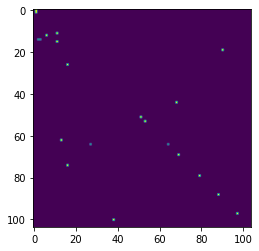

In [33]:
confusion_matrix = np.zeros(shape=[104, 104])
class_cnt = np.zeros(shape=[104,1])
model.eval()
with torch.no_grad():
  # for i, data in enumerate(trainloader, 0):
  for i, data in enumerate(valloader, 0):
      # if i % print_every == 0 and i>0:
        # print("Val batch ",i+1)

      if model_input == "resnet 18 image features, question" or model_input == "resnet 192 image features, question" or model_input == "new resnet 18 features" or model_input == "new resnet 152 features":
        image_features, questions, labels, q_indices = data
        # questions = questions/3100
        # questions = questions[:,:5]
        image_features = image_features.type(torch.float32)
        labels = labels.flatten().type(torch.long)
        labels = labels.view(-1)

        outputs = model(image_features, questions, q_indices)

      # print(outputs.size())
      outputs = torch.argmax(outputs, axis=1).detach().numpy()
      labels = labels.detach().numpy()
      print(labels.shape)
      print(outputs.shape)
      for j in range(labels.shape[0]):
        class_cnt[labels[i]] += 1
        confusion_matrix[labels[i], outputs[i]] += 1
      # batch_correct, batch_total = get_accuracy(outputs, labels)
      # val_correct += batch_correct
      # val_total += batch_total
      # val_batches += 1

      # val_loss = focal_loss(outputs, labels, alpha=alpha, gamma=gamma)
      # # val_loss = criterion(outputs, labels)
      # val_total_loss += val_loss.detach().numpy()

class_cnt += 1e-5
confusion_matrix = (confusion_matrix/class_cnt)*100

import matplotlib.pyplot as plt

plt.imshow(confusion_matrix)
plt.show()


In [34]:
accuracy_list = []
for i in range(104):
  accuracy_list.append((confusion_matrix[i,i], i))

accuracy_list.sort()
print(accuracy_list[:10])
accuracy_list.reverse()
print(accuracy_list[:10])

[(0.0, 0), (0.0, 2), (0.0, 3), (0.0, 4), (0.0, 5), (0.0, 6), (0.0, 7), (0.0, 8), (0.0, 9), (0.0, 10)]
[(99.99999900000002, 97), (99.99999900000002, 88), (99.99999900000002, 79), (99.99999900000002, 69), (99.99999900000002, 53), (99.99999900000002, 51), (99.99999900000002, 11), (99.99999900000002, 1), (49.99999975, 64), (0.0, 103)]


In [45]:
correct_arr = np.zeros(shape=[104, 1])
total_arr = np.zeros(shape=[104, 1])

model.eval()
with torch.no_grad():
  # for i, data in enumerate(trainloader, 0):
  for i, data in enumerate(valloader, 0):
      # if i % print_every == 0 and i>0:
        # print("Val batch ",i+1)

      if model_input == "resnet 18 image features, question" or model_input == "resnet 192 image features, question" or model_input == "new resnet 18 features" or model_input == "new resnet 152 features":
        image_features, questions, labels, q_indices = data
        # questions = questions/3100
        # questions = questions[:,:5]
        image_features = image_features.type(torch.float32)
        labels = labels.flatten().type(torch.long)
        labels = labels.view(-1)

        outputs = model(image_features, questions, q_indices)

      # print(outputs.size())
      outputs = torch.argmax(outputs, axis=1).detach().numpy()
      labels = labels.detach().numpy()
      print(labels.shape)
      print(outputs.shape)
      for j in range(labels.shape[0]):
        if labels[j] == outputs[j]:
          correct_arr[labels[j]] += 1
        total_arr[labels[j]] += 1
        
accuracy_list = []

for i in range(104):
  v = (correct_arr[i,0]/(total_arr[i,0]+1e-8))*100.0
  accuracy_list.append((v, answer_dict[i], correct_arr[i,0], total_arr[i,0]))

accuracy_list.sort()
print(accuracy_list[:10])
accuracy_list.reverse()
print(accuracy_list[:10])

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(283,)
(283,)
[(0.6289308175705075, '15', 1.0, 159.0), (1.4925373133585802, '7', 3.0, 201.0), (1.4925373133585802, '9', 3.0, 201.0), (2.487562188930967, '12', 5.0, 201.0), (2.487562188930967, 'purple', 5.0, 201.0), (3.4825870645033534, '6', 7.0, 201.0), (4.102564102353715, 'many', 8.0, 195.0), (4.47761194007574, '10', 9.0, 201.0), (4.47761194007574, '20', 9.0, 201.0), (4.975124377861934, '8', 10.0, 201.0)]
[(88.0434782560846, 'night', 162.0, 184.0), (83.0845771102943, 'wii', 167.0, 201.0), (82.5870646725081, 'baseball', 166.0, 201.0), (81.09452735914952, 'giraffe', 163.0, 201.0), (79.60199004579094, 'broccoli', 160.0, 201.0), (79.10447760800476, 'stop', 159.0, 201.0), (78

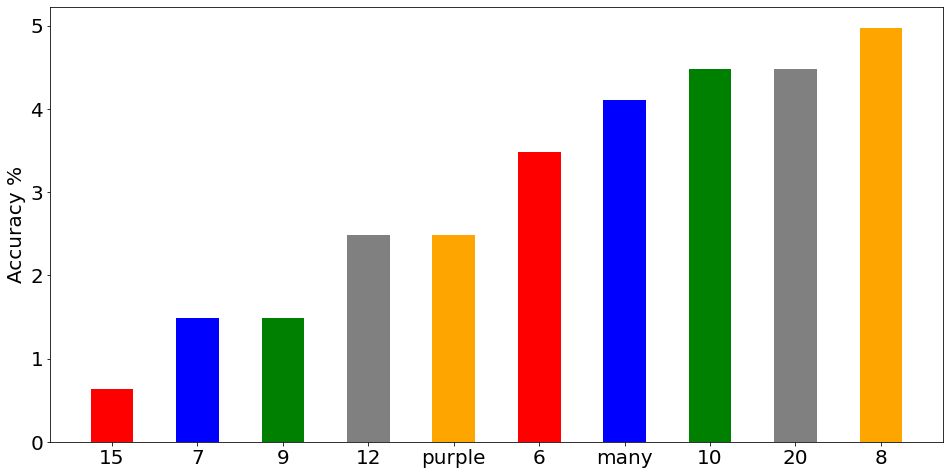

In [95]:
x = np.arange(1, 11)*1
plt.figure(figsize=(16,8))
accuracy_list.sort()
y = np.zeros_like(x, dtype=np.float32)
c = ['red', 'blue', 'green', 'gray', 'orange']
labels = []
for i in range(10):
  y[i] = accuracy_list[i][0]
  labels.append(accuracy_list[i][1])
plt.bar(x, y, color=c, tick_label=labels, width=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Accuracy %", fontdict={'size': 20})

plt.show()

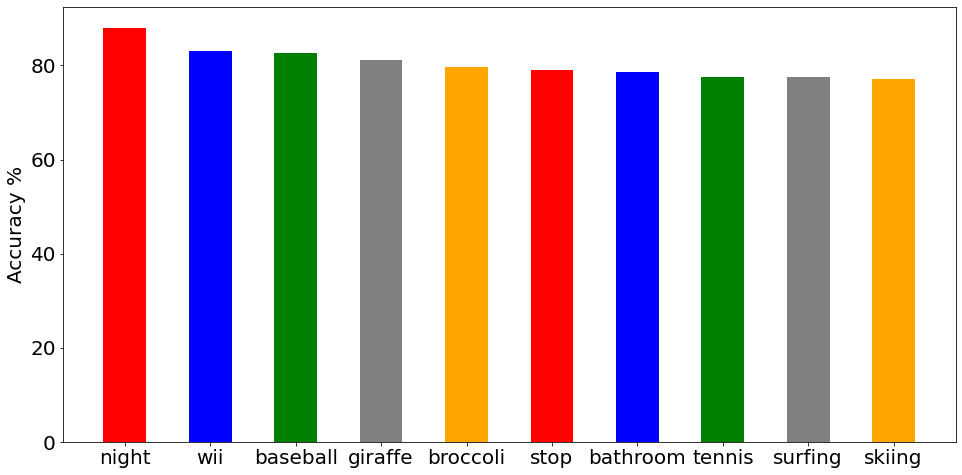

In [94]:
x = np.arange(1, 11)*1

plt.figure(figsize=(16,8))
accuracy_list.sort()
accuracy_list.reverse()
y = np.zeros_like(x, dtype=np.float32)
c = ['red', 'blue', 'green', 'gray', 'orange']
labels = []
for i in range(10):
  y[i] = accuracy_list[i][0]
  labels.append(accuracy_list[i][1])
plt.bar(x, y, color=c, tick_label=labels, width=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Accuracy %", fontdict={'size': 20})
plt.show()

In [96]:
print(answer_dict)

{0: 'no', 1: 'yes', 2: '2', 3: '1', 4: 'white', 5: '3', 6: 'black', 7: 'red', 8: 'blue', 9: '0', 10: '4', 11: 'brown', 12: 'green', 13: 'yellow', 14: '5', 15: 'gray', 16: 'nothing', 17: 'right', 18: 'left', 19: 'frisbee', 20: 'baseball', 21: '6', 22: 'wood', 23: 'tennis', 24: 'orange', 25: 'none', 26: 'pizza', 27: 'kitchen', 28: 'bathroom', 29: 'cat', 30: 'pink', 31: '7', 32: '8', 33: 'skiing', 34: 'skateboarding', 35: 'man', 36: 'grass', 37: 'water', 38: 'dog', 39: 'silver', 40: 'surfing', 41: '10', 42: 'black and white', 43: 'kite', 44: 'horse', 45: 'skateboard', 46: 'phone', 47: 'wii', 48: 'living room', 49: 'stop', 50: 'giraffe', 51: 'eating', 52: 'woman', 53: 'surfboard', 54: 'broccoli', 55: 'sunny', 56: 'hat', 57: 'cake', 58: 'snow', 59: '9', 60: 'standing', 61: 'banana', 62: 'purple', 63: 'food', 64: 'table', 65: 'camera', 66: 'beach', 67: 'male', 68: 'elephant', 69: 'train', 70: 'flowers', 71: 'snowboarding', 72: '12', 73: 'sheep', 74: 'laptop', 75: 'apple', 76: 'cow', 77: 'win

In [97]:
# correct_arr = np.zeros(shape=[104, 1])
# total_arr = np.zeros(shape=[104, 1])
pred_arr = np.zeros(shape=[104, 1])

model.eval()
with torch.no_grad():
  # for i, data in enumerate(trainloader, 0):
  for i, data in enumerate(valloader, 0):
      # if i % print_every == 0 and i>0:
        # print("Val batch ",i+1)

      if model_input == "resnet 18 image features, question" or model_input == "resnet 192 image features, question" or model_input == "new resnet 18 features" or model_input == "new resnet 152 features":
        image_features, questions, labels, q_indices = data
        # questions = questions/3100
        # questions = questions[:,:5]
        image_features = image_features.type(torch.float32)
        labels = labels.flatten().type(torch.long)
        labels = labels.view(-1)

        outputs = model(image_features, questions, q_indices)

      # print(outputs.size())
      outputs = torch.argmax(outputs, axis=1).detach().numpy()
      labels = labels.detach().numpy()
      print(labels.shape)
      print(outputs.shape)
      for j in range(labels.shape[0]):
        # if labels[j] == outputs[j]:
          # correct_arr[labels[j]] += 1
        # total_arr[labels[j]] += 1
        pred_arr[outputs[j]] += 1
        
# accuracy_list = []

# for i in range(104):
#   v = (correct_arr[i,0]/(total_arr[i,0]+1e-8))*100.0
#   accuracy_list.append((v, answer_dict[i], correct_arr[i,0], total_arr[i,0]))

# accuracy_list.sort()
# print(accuracy_list[:10])
# accuracy_list.reverse()
# print(accuracy_list[:10])
pred_list = []

for i in range(104):
  v = pred_arr[i,0]
  pred_list.append((v, answer_dict[i]))

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(283,)
(283,)


In [1]:
pred_list.sort()
pred_list.reverse()
print(pred_list)

NameError: ignored

In [0]:
num = 100
x = np.arange(1, num+1)*1

fig, axes = plt.subplots(1, 1, figsize=(320, 160), dpi=200)
# plt.figure(figsize=(320,160))
pred_list.sort()
pred_list.reverse()
y = np.zeros_like(x, dtype=np.float32)
c = ['red', 'blue', 'green', 'gray', 'orange']
labels = []
for i in range(num):
  y[i] = pred_list[i][0]
  labels.append(pred_list[i][1])
plt.bar(x, y, color=c, tick_label=labels, width=0.5)
plt.xticks(fontsize=200)
plt.yticks(fontsize=200)
plt.ylabel("Predictions Frequency", fontdict={'size': 20})
plt.show()

In [0]:
import json 
  
# JSON file
def read_json(filename): 
  f = open (filename, "r") 
    
  # Reading from file 
  data = json.loads(f.read()) 
  return data

dataset = read_json("PythonHelperTools/combined_filtered_train_dataset_32k.json")

answer_dict = {}

for i in range(len(dataset)):
  # print(dataset[i])
  # break
  ans = dataset[i]['answer']
  ans_id = dataset[i]['answer_id']
  if ans_id not in answer_dict:
    answer_dict[ans_id] = ans


In [0]:
mcnt_dict = {}

for i in range(len(train_answers)):
  v = train_answers[i][0]
  if v not in cnt_dict:
    cnt_dict[v] = 1
  else:
    cnt_dict[v] = cnt_dict[v] + 1
print(cnt_dict)

cnt_list = []
for key in cnt_dict.keys():
  v = cnt_dict[key]
  if v > 50:
    cnt_list.append((key,v))

print(len(cnt_list))

In [0]:
print(train_questions.shape)

In [0]:
print(train_questions[0])

In [13]:
print(train_questions[100])

[1.970e+02 1.090e+02 6.900e+01 3.200e+01 5.015e+03 4.000e+05 4.000e+05
 4.000e+05 4.000e+05 4.000e+05 4.000e+05 4.000e+05 4.000e+05 4.000e+05
 4.000e+05 4.000e+05 4.000e+05 4.000e+05 4.000e+05 4.000e+05 4.000e+05
 4.000e+05 4.000e+05 4.000e+05 4.000e+05]


In [0]:
ti = 

In [0]:
t = torch.tensor([[[1,11],[2,12]],[[3,13],[4,14]]])
print(t.size())
r = torch.gather(t, 1, torch.tensor([[[0,0]],[[1,1]]]))
print(r.size())
print(t)
print(r)

In [0]:
import numpy as np
import torch 
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt 

answer_type = "number"


train_image = np.load("vgg_train_image_features_"+answer_type+".npy")
train_image = np.reshape(train_image, newshape=[train_image.shape[0], train_image.shape[1], train_image.shape[2]*train_image.shape[3]])
print(train_image.shape)

val_image = np.load("vgg_val_image_features_"+answer_type+".npy")
val_image = np.reshape(val_image, newshape=[val_image.shape[0], val_image.shape[1], val_image.shape[2]*val_image.shape[3]])
print(val_image.shape)

train_question = np.load("train_questions_"+answer_type+".npy")
val_question = np.load("val_questions_"+answer_type+".npy")

qword_dict = {}
cnt = 0
for i in range(train_question.shape[0]):
  for j in range(train_question.shape[1]):
    word = train_question[i,j]
    if word not in qword_dict:
      qword_dict[word] = cnt
      cnt += 1

for i in range(val_question.shape[0]):
  for j in range(val_question.shape[1]):
    word = val_question[i,j]
    if word not in qword_dict:
      qword_dict[word] = cnt
      cnt += 1

for i in range(train_question.shape[0]):
  for j in range(train_question.shape[1]):
    word = train_question[i,j]
    train_question[i,j] = qword_dict[word]

for i in range(val_question.shape[0]):
  for j in range(val_question.shape[1]):
    word = val_question[i,j]
    val_question[i,j] = qword_dict[word]

# print("cnt = ",cnt)

train_answer = np.load("train_answers_"+answer_type+".npy").astype(int)
# print(train_question.shape)
# print(train_answer.shape)
# print(train_answer.dtype)

val_answer = np.load("val_answers_"+answer_type+".npy").astype(int)
# print(val_question.shape)
# print(val_answer.shape)
# print(val_answer.dtype)

# print(train_question[:2])
# print(val_question[:2])

#all_images = np.concatenate((train_image,val_image), axis=0)
#all_questions = np.concatenate((train_question,val_question),axis=0)
#all_answers = np.concatenate((train_answer,val_answer), axis = 0)

#print(all_images.shape)
#print(all_questions.shape)
#print(all_answers.shape)

#indices = np.arange(6000)
#random.shuffle(indices)

#all_images = all_images[indices,:]
#all_questions = all_questions[indices,:]
#all_answers = all_answers[indices, :]

#train_image = all_images [:4000, :]
#val_image = all_images[4000:,:]

#train_question = all_questions[:4000,:]
#val_question = all_questions[4000:,:]

#train_answer = all_answers[:4000,:].astype(int)
#val_answer = all_answers[4000:,:].astype(int)

#print(train_image.shape)
#print(train_question.shape)
#print(train_answer.shape)

#print(val_image.shape)
#print(val_question.shape)
#print(val_answer.shape)

#a ,b = np.unique(train_answer, return_counts=True)
#print(a)
#print(b)

#a ,b = np.unique(val_answer, return_counts=True)
#print(a)
#print(b)

class ParallelCoAttention(nn.Module):
  def __init__(self, d, t, k, vocab_size, dropout):
    super(ParallelCoAttention, self).__init__()
    self.d = d 
    self.embedding_dim = d
    self.t = t
    self.k = k
    self.vocab_size = vocab_size
    self.dropout = nn.Dropout(dropout)

    self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
    self.W_b = nn.Linear(self.d, self.d)
    self.W_q = nn.Linear(self.d, self.k)
    self.W_v = nn.Linear(self.d, self.k)
    self.w_hv = nn.Linear(self.k, 1)
    self.w_hq = nn.Linear(self.k, 1)
    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim =1)


  def forward(self, questions, images):
    # print("here 1")
    questions = self.embedding(questions)
    # print("here 2")
    x = self.dropout(self.W_b(questions))#self.W_b(questions)
    # print("here 3")
    C = self.tanh(torch.bmm(x,images)) 
    # print("here 4")

    H_v = self.tanh(self.dropout(self.W_v(torch.transpose(images, 1, 2)) + torch.bmm(torch.transpose(C,1,2),self.W_q(questions)))) #self.tanh(self.W_v(torch.transpose(images, 1, 2)) + torch.bmm(torch.transpose(C,1,2),self.W_q(questions)))
    # print("here 5")
    a_v = self.softmax(self.dropout(self.w_hv(H_v)))#self.softmax(self.w_hv(H_v))
    # print("here 6")
    a_v = torch.transpose(a_v, 1,2) 
    # print("here 7")
    v_hat = torch.sum(a_v * images, axis= 2) 
    # print("here 8")

    H_q = self.tanh(self.dropout(self.W_q(questions) + torch.bmm(C,self.W_v(torch.transpose(images, 1, 2))))) #self.tanh(self.W_q(questions) + torch.bmm(C,self.W_v(torch.transpose(images, 1, 2))))
    # print("here 9")
    a_q = self.softmax(self.dropout(self.w_hq(H_q)))#self.softmax(self.w_hq(H_q))
    # print("here 10")
    q_hat = torch.sum(a_q*questions, axis =1) 
    # print("here 11")
    return (q_hat, v_hat)

class AlternateCoAttention(nn.Module):
  def __init__(self, d, k, vocab_size, dropout):
    super(AlternateCoAttention, self).__init__()
    self.d = d
    self.k = k
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(self.vocab_size, self.d)
    self.dropout = nn.Dropout(dropout)

    self.W_x_1 = nn.Linear(self.d, self.k)
    self.W_g_1 = nn.Linear(self.d, self.k)
    self.W_hx_1 = nn.Linear(self.k, 1)

    self.W_x_2 = nn.Linear(self.d, self.k)
    self.W_g_2 = nn.Linear(self.d, self.k)
    self.W_hx_2 = nn.Linear(self.k, 1)

    self.W_x_3 = nn.Linear(self.d, self.k)
    self.W_g_3 = nn.Linear(self.d, self.k)
    self.W_hx_3 = nn.Linear(self.k, 1)

    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, questions, images):
    # print("there 1")
    questions = self.embedding(questions)
    # print("there 2")
    H_1 = self.tanh(self.dropout(self.W_x_1(questions)))#self.tanh(self.W_x_1(questions))
    # print("there 3")
    a_x_1 = self.softmax(self.dropout(self.W_hx_1(H_1))) #self.softmax(self.W_hx_1(H_1))
    # print("there 4")
    x_hat_1 = torch.sum(a_x_1 * questions, axis=1) 

    # print("there 5")
    H_2 = self.tanh(self.dropout(self.W_x_2(torch.transpose(images,1,2)) + self.W_g_2(x_hat_1).unsqueeze(1)))#self.tanh(self.W_x_2(torch.transpose(images,1,2)) + self.W_g_2(x_hat_1).unsqueeze(1))
    # print("there 6")
    a_x_2 = self.softmax(self.dropout(self.W_hx_2(H_2)))#self.softmax(self.W_hx_2(H_2))
    # print("there 7")
    x_hat_2 = torch.sum(a_x_2*torch.transpose(images,1,2), axis=1)

    # print("there 8")
    H_3 = self.tanh(self.dropout(self.W_x_3(questions) + self.W_g_3(x_hat_2).unsqueeze(1)))#self.tanh(self.W_x_3(questions) + self.W_g_3(x_hat_2).unsqueeze(1))
    # print("there 9")
    a_x_3 = self.softmax(self.dropout(self.W_hx_3(H_3)))#self.softmax(self.W_hx_3(H_3))
    # print("there 10")
    x_hat_3 = torch.sum(a_x_3*questions, axis=1)
    # print("there 11")
    return (x_hat_2, x_hat_3)

class AnswerGeneration(nn.Module):
  def __init__(self, d, d_prime, dropout):
    super(AnswerGeneration, self).__init__()
    self.d = d
    self.d_prime = d_prime
    self.dropout = nn.Dropout(dropout)

    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim = 1)
    self.W = nn.Linear(self.d, self.d_prime)
    self.W_h = nn.Linear(self.d_prime,  100) #no of classes for yesno -2, number - 100, other - 1000 --verify again 

  def forward(self, q_hat, v_hat):
    h = self.tanh(self.dropout(self.W(q_hat + v_hat)))#self.tanh(self.W(q_hat + v_hat))
    return self.W_h(h)#self.softmax(self.W_h(h))

class Fusion(nn.Module):
  def __init__(self, shared_size):
    self.shared_size = shared_size
    super(Fusion, self).__init__()
    self.qp_qa = nn.Linear(512, 512)
    self.bn1 = nn.BatchNorm1d(512)
    self.qpa_qs = nn.Linear(512, self.shared_size)
    self.bn2 = nn.BatchNorm1d(self.shared_size)

    self.qa_qp = nn.Linear(512, 512)
    self.bn3 = nn.BatchNorm1d(512)
    self.qap_qs = nn.Linear(512, self.shared_size)
    self.bn4 = nn.BatchNorm1d(self.shared_size)

    self.vp_va = nn.Linear(512, 512)
    self.bn5 = nn.BatchNorm1d(512)
    self.vpa_vs = nn.Linear(512, self.shared_size)
    self.bn6 = nn.BatchNorm1d(self.shared_size)

    self.va_vp = nn.Linear(512, 512)
    self.bn7 = nn.BatchNorm1d(512)
    self.vap_vs = nn.Linear(512, self.shared_size)
    self.bn8 = nn.BatchNorm1d(self.shared_size)

  def forward(self, q_hat_p, v_hat_p, q_hat_a, v_hat_a):
    fq1 = self.bn2(self.qpa_qs((self.bn1(self.qp_qa(q_hat_p)+q_hat_a))))
    fq2 = self.bn4(self.qap_qs((self.bn3(self.qa_qp(q_hat_a)+q_hat_p))))
    fq = fq1*fq2

    fv1 = self.bn6(self.vpa_vs((self.bn5(self.vp_va(v_hat_p)+v_hat_a))))
    fv2 = self.bn8(self.vap_vs((self.bn7(self.va_vp(v_hat_a)+v_hat_p))))
    fv = fv1*fv2

    return fq, fv


class MainModel(nn.Module):
  def __init__(self, d, t, k, d_prime, vocab_size, dropout, shared_size):
    super(MainModel, self).__init__()
    self.d = d
    self.t = t
    self.k = k 
    self.d_prime = d_prime
    self.vocab_size = vocab_size
    self.dropout = dropout
    self.shared_size = shared_size

    self.parallel = ParallelCoAttention(self.d, self.t, self.k, self.vocab_size, self.dropout)
    self.alternate = AlternateCoAttention(self.d, self.k, self.vocab_size, self.dropout)
    self.fusion = Fusion(shared_size)
    self.answer = AnswerGeneration(self.shared_size, self.d_prime, self.dropout)
    


  def forward(self, questions, images):
    # print("parallel start")
    q_hat_p, v_hat_p = self.parallel(questions, images)
    # print("parallel end")
    # print("alt start")
    v_hat_a, q_hat_a = self.alternate(questions, images)
    # print(q_hat_p.size())
    # print(v_hat_p.size())
    # print(q_hat_a.size())
    # print(v_hat_a.size())
    fq, fv = self.fusion(q_hat_p, v_hat_p, q_hat_a, v_hat_a)
    # print("alt end")
    # answer_p = self.answer(q_hat_p, v_hat_p)
    # answer_a = self.answer(q_hat_a, v_hat_a)
    answer = self.answer(fq, fv)
    return answer
    # return (answer_p, answer_a)

d = 512
t = 25
k = 512
d_prime = 128 
vocab_size = cnt
dropout = 0.5
shared_size = 129

model = MainModel(d, t, k, d_prime, vocab_size, dropout, shared_size)
# model.load_state_dict(torch.load("output/model.pt"))


tensor_x = torch.Tensor(train_question).type(torch.long)
tensor_y = torch.Tensor(train_image).type(torch.float)
tensor_z = torch.Tensor(train_answer).type(torch.long).squeeze()

trainset = data.TensorDataset(tensor_x, tensor_y, tensor_z)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1000, shuffle = True, num_workers=2)

tensor_x = torch.Tensor(val_question).type(torch.long)
tensor_y = torch.Tensor(val_image).type(torch.float)
tensor_z = torch.Tensor(val_answer).type(torch.long).squeeze()

valset = data.TensorDataset(tensor_x, tensor_y, tensor_z)
valloader = torch.utils.data.DataLoader(valset, batch_size = 1000, shuffle = True, num_workers = 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=4e-5, weight_decay=1e-6, momentum=0.99)

def get_accuracy(predictions, labels):
  predictions = F.softmax(predictions,dim=1)
  predictions = torch.max(predictions, axis=1)[1]
  #predictions = predictions.detach().numpy()
  #correct = predictions.eq(labels).sum()
  ab = torch.abs(predictions-labels)
  ab = ab.detach().numpy()
  mn = np.minimum(ab, 1)
  eq = 1-mn
  correct = np.sum(eq)
  total = eq.shape[0]
  #total = predictions.shape[0]
  return correct, total

train_loss_plot = []
val_loss_plot = []

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    total_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        questions, images, labels = data
      
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs_p, outputs_a = model(questions, images)
        # batch_correct, batch_total = get_accuracy(outputs_p, labels)
        outputs = model(questions, images)
        batch_correct, batch_total = get_accuracy(outputs, labels)
        correct += batch_correct
        total += batch_total
        # loss = criterion(outputs_a, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += running_loss
        running_loss = 0.0
    

    running_val_loss = 0.0
    total_val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          questions, images, labels = data

          # forward + backward + optimize
          # outputs_p, outputs_a = model(questions, images)
          # batch_correct, batch_total = get_accuracy(outputs_p, labels)
          outputs = model(questions, images)
          batch_correct, batch_total = get_accuracy(outputs, labels)
          val_correct += batch_correct
          val_total += batch_total
          # loss = criterion(outputs_a, labels)
          loss = criterion(outputs, labels)

          running_val_loss += loss.item()
          total_val_loss += running_val_loss
          running_val_loss = 0.0
          
    # with open("output/output.txt","a") as f:
    #     f.write("Epoch: "+str(epoch)+" Train Loss: "+str(total_loss)+" Val Loss "+str(total_val_loss)+" Train Correct "+str(correct)+" Val Correct "+str(val_correct)+" Train-Accuracy: "+str(correct/total)+" Val-Accuracy: "+str(val_correct/val_total))
    #     f.write("\n")
    # f.close()

    print("Epoch: ",epoch, " Train Loss ",total_loss," Val Loss ", total_val_loss, " Train Accuracy ",correct/total, " Val Accuracy ", val_correct/val_total)

    train_loss_plot.append(total_loss)
    val_loss_plot.append(total_val_loss)

    # with open("output/train_loss.txt","a") as f:
    #     f.write(str(total_loss))
    #     f.write("\n")
    # f.close()
   
    # with open("output/val_loss.txt","a") as f:
    #     f.write(str(total_val_loss))
    #     f.write("\n")
    # f.close()
    # torch.save(model.state_dict(),"output/model.pt")
    #plt.plot(np.arange(epoch+1),train_loss_plot)
    #plt.plot(np.arange(epoch+1),val_loss_plot)
    #plt.show()

print('Finished Training')